### Imports

In [1]:
# Importing necessary libraries and modules

# General
import numpy as np  # Importing numpy for numerical operations

# Data Management
import pandas as pd  # Importing pandas for data manipulation and analysis
import polars as pl
from sklearn.model_selection import train_test_split  # Importing train_test_split for splitting data into training and testing sets

# Machine Learning
from xgboost import XGBClassifier  # Importing XGBClassifier for extreme gradient boosting classification
from sklearn.model_selection import RandomizedSearchCV, cross_val_score  # Importing RandomizedSearchCV for hyperparameter tuning, cross_val_score for cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold  # Importing RepeatedStratifiedKFold for repeated stratified k-fold cross-validation

# Binary Classification Specific Metrics
# Alternative method for plotting the ROC curve
from sklearn.metrics import roc_curve, auc  # Importing roc_curve and auc for ROC curve and AUC calculation

# General Metrics
from sklearn.metrics import accuracy_score, classification_report  # Importing accuracy_score and classification_report for model evaluation
from sklearn.metrics import precision_score, confusion_matrix  # Importing precision_score and confusion_matrix for precision and confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay  # Importing ConfusionMatrixDisplay for displaying confusion matrix

# Reporting
import matplotlib.pyplot as plt  # Importing pyplot from matplotlib for plotting
from matplotlib.pylab import rcParams  # Importing rcParams from matplotlib for setting plot parameters
from xgboost import plot_tree  # Importing plot_tree from xgboost for visualizing decision trees

# Function to plot ROC curve
def plot_roc(model, X_test, y_test):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

### Data Management

In [2]:
# Data Extraction

df = pl.read_csv("data/BTC-USD.csv") # Read the CSV file into a polars df


df = df.with_columns(pl.col("date").cast(pl.Datetime)) # now will have datetime dtype

# Sort the DataFrame by the 'date' column in ascending order, argument ensures oldest dates come first.
df = df.sort("date", descending=False)

### Add Target

In [3]:
# Specify Target
df = df.with_columns([
    (pl.when(pl.col('range').shift(-1) > pl.col('average range'))  # Compare the 'range' shift less one column with 'average range'
        .then(1)  # If the condition is true, set 'TARGET' to 1
        .otherwise(0))  # If the condition is false, set 'TARGET' to 0
        .alias('TARGET')  # Name the new column 'TARGET'
])
# This allows you to create a target variable based on whether the 'range' of the next day is greater than or less than
# the 'average range' of the current day.

In [4]:
# Check for NaNs
nan_location = df.select(pl.all().is_null()).to_numpy().nonzero()
# pl.all().is_null(): Creates a boolean mask for NaNs.
# .to_numpy(): Converts the mask to a NumPy array.
# .nonzero(): Retrieves the indices of the True values in the boolean mask, indicating the positions of NaNs.

nan_location

(array([], dtype=int64), array([], dtype=int64))

In [5]:
# Fill NA if needed
df = df.with_columns(pl.col("TARGET").fill_nan(0))
df.tail()

date,DOW,open,high,low,close,adj_close,volume,returns,range,Bench_C_Rets,RSI,RSI_Ret,MA_12,MA_21,rolling returns,average range,returns_1,range_1,RSI_Ret_1,returns_2,range_2,RSI_Ret_2,returns_3,range_3,RSI_Ret_3,returns_4,range_4,RSI_Ret_4,returns_5,range_5,RSI_Ret_5,returns_6,range_6,RSI_Ret_6,returns_7,range_7,RSI_Ret_7,TARGET
datetime[μs],i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
2024-07-14 00:00:00,6,0.022734,0.025799,0.024721,60787.792969,60787.792969,0.301132,0.026267,0.03553,0.163694,44.348685,0.982906,57973.966146,59473.93006,-0.075268,0.034931,0.023014,0.034442,1.060974,0.00967,0.034324,1.136591,-0.006885,0.038148,0.909442,-0.004598,0.038144,1.041948,0.022998,0.034134,0.981631,0.015327,0.070144,1.25864,-0.042097,0.046203,0.931954,1
2024-07-15 00:00:00,0,0.02685,0.057731,0.024984,64870.152344,64870.152344,0.714162,0.067158,0.068614,0.162156,54.890198,1.237696,58365.318685,59692.631882,-0.010836,0.03695,0.026267,0.03553,0.982906,0.023014,0.034442,1.060974,0.00967,0.034324,1.136591,-0.006885,0.038148,0.909442,-0.004598,0.038144,1.041948,0.022998,0.034134,0.981631,0.015327,0.070144,1.25864,1
2024-07-16 00:00:00,1,0.065262,0.007464,0.029372,65097.148438,65097.148438,0.092476,0.003499,0.045871,0.162061,57.655443,1.050378,59041.939128,59849.417969,-0.014105,0.038036,0.067158,0.068614,1.237696,0.026267,0.03553,0.982906,0.023014,0.034442,1.060974,0.00967,0.034324,1.136591,-0.006885,0.038148,0.909442,-0.004598,0.038144,1.041948,0.022998,0.034134,0.981631,0
2024-07-17 00:00:00,2,0.004745,0.0109,0.022534,64118.792969,64118.792969,-0.218473,-0.015029,0.033972,0.161807,60.293388,1.045754,59663.307292,60006.918713,-0.026902,0.038097,0.003499,0.045871,1.050378,0.067158,0.068614,1.237696,0.026267,0.03553,0.982906,0.023014,0.034442,1.060974,0.00967,0.034324,1.136591,-0.006885,0.038148,0.909442,-0.004598,0.038144,1.041948,0
2024-07-18 00:00:00,3,-0.015165,-0.014562,-0.010172,63974.066406,63974.066406,-0.162514,-0.002257,0.029385,0.161775,71.713449,1.189408,60135.851237,60119.740885,-0.008863,0.037781,-0.015029,0.033972,1.045754,0.003499,0.045871,1.050378,0.067158,0.068614,1.237696,0.026267,0.03553,0.982906,0.023014,0.034442,1.060974,0.00967,0.034324,1.136591,-0.006885,0.038148,0.909442,0


### Train Test Split

In [6]:
# Feature Selection. We are using the features identified as the top
df_tts = df.clone()

# Select the specified columns
df_tts = df_tts.select([
    "DOW", 
    "volume", 
    "returns", 
    "range", 
    "RSI", 
    "average range", 
    "range_1",
    "range_2", 
    "RSI_Ret_2", 
    "range_4", 
    "range_6",
    "TARGET"
])

# Display the first few rows of the new DataFrame
df_tts.tail(5)


DOW,volume,returns,range,RSI,average range,range_1,range_2,RSI_Ret_2,range_4,range_6,TARGET
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
6,0.301132,0.026267,0.03553,44.348685,0.034931,0.034442,0.034324,1.136591,0.038144,0.070144,1
0,0.714162,0.067158,0.068614,54.890198,0.03695,0.03553,0.034442,1.060974,0.038148,0.034134,1
1,0.092476,0.003499,0.045871,57.655443,0.038036,0.068614,0.03553,0.982906,0.034324,0.038144,0
2,-0.218473,-0.015029,0.033972,60.293388,0.038097,0.045871,0.068614,1.237696,0.034442,0.038148,0
3,-0.162514,-0.002257,0.029385,71.713449,0.037781,0.033972,0.045871,1.050378,0.03553,0.034324,0


In [7]:
# Split into Learning (X) and Target (y) Data

# Last column is the target column
target_column = "TARGET"

# Select feature columns and target column
feature_columns = [
    "DOW", 
    "volume", 
    "returns", 
    "range", 
    "RSI", 
    "average range", 
    "range_1",
    "range_2", 
    "RSI_Ret_2", 
    "range_4", 
    "range_6"
]

# Create X (features) and y (target), needs to be in numpy since sklearn uses numpy or pandas
X = df_tts.select(feature_columns).to_numpy()
y = df_tts.select([target_column]).to_numpy().ravel()  # Ensure y is a 1D array


# Display the first 3 rows of the numpy arrays X and y
print("First 3 rows of X:")
print(X[:3])

print(" ")

# Display the first 3 elements of the numpy array y_train
print("First 3 elements of y:")
print(y[:3])

First 3 rows of X:
[[ 1.00000000e+00  1.10389478e+00  5.43480805e-02  5.54422058e-02
   6.72213683e+01  5.79102306e-02  3.88697735e-03  4.64562778e-03
   9.84746588e-01  8.05486304e-03  1.29698003e-02]
 [ 2.00000000e+00 -8.79318516e-02  1.91878991e-02  1.89257384e-02
   7.86593444e+01  5.73809963e-02  5.54422058e-02  3.88697735e-03
   9.83884377e-01  4.45747739e-03  1.89553700e-02]
 [ 3.00000000e+00 -2.85724335e-02  2.30297751e-02  3.08160739e-02
   7.98249504e+01  5.76747094e-02  1.89257384e-02  5.54422058e-02
   9.41683925e-01  4.64562778e-03  8.05486304e-03]]
 
First 3 elements of y:
[0 0 0]


In [8]:
# Perform Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of the train and test sets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (2180, 11)
Shape of y_train:  (2180,)
Shape of X_test:  (546, 11)
Shape of y_test:  (546,)


In [9]:
# Perform Train Test Split (Timeseries based method)
# Define the training size rate
train_size_rate = 0.7

# Calculate the number of training samples
train_size = int(len(X) * train_size_rate)

# Calculate the number of testing samples
test_size = len(X) - train_size

# Split the features (X) and target (y) into training and testing sets
# The first 'train_size' rows for training and the remaining rows for testing
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# Validate that the sizes match
size_check = (len(y_test) + len(y_train)) == len(y)

# Print shapes of the training and testing sets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)



Shape of X_train:  (1908, 11)
Shape of y_train:  (1908,)
Shape of X_test:  (818, 11)
Shape of y_test:  (818,)
Size Matches:  True


### Build Model

In [10]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

# Purpose:
# is_binary: 
#   - True: We're building a binary classification model
#   - False: We're building a multi-class classification model
# This flag determines the objective function and evaluation metrics we use.

In [11]:
# Determine Objective and Evaluation Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [12]:
# Refine Evaluation Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"  # Area Under the Precision-Recall Curve
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"  # Area Under the ROC Curve
    scoring = "f1"  # F1 Score balances precision and recall
else:
    scoring = "accuracy"


In [13]:
(eval_metric, eval_metric_list)

('aucpr', ['error', 'logloss', 'logloss'])

In [14]:
# Copied from sec9.69 Feature Selection. There we algorithmically came up with the Hyperparams
# Hyperparams: ne: 100, lr: 0.1 md: 3 gm: 6
ne = 50 # number of estimators
lr = 0.1 # learning rate
md = 3 # max depth
gm = 6 # gamma

In [15]:
# XGBOOST Classifier
from xgboost import XGBClassifier

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

#This is proper way to do it I am loading config used by the instructor
classifier = XGBClassifier(
    objective=objective,  
    booster="gbtree",  
    eval_metric=eval_metric_list,  
    n_estimators=ne,  
    learning_rate=lr,  
    max_depth=md,  
    gamma=gm,  
    subsample=0.8,  
    colsample_bytree=1,  # All features considered for each tree
    random_state=1,  # Ensures reproducibility
    use_label_encoder=False  # Prevents auto-encoding of string labels (avoids warnings)
)

# # Instructor config
# classifier = XGBClassifier(
#     base_score=0.5, booster='gbtree', colsample_bylevel=1,
#     colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
#     eval_metric='aucpr', gamma=6, gpu_id=-1, importance_type=None,
#     interaction_constraints='', learning_rate=0.01, max_delta_step=0,
#     max_depth=3, min_child_weight=1, missing=float('nan'),
#     monotone_constraints='()', n_estimators=80, n_jobs=8,
#     num_parallel_tree=1, predictor='auto', random_state=1,
#     reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
#     tree_method='exact', use_label_encoder=False,
#     validate_parameters=1, verbosity=None
# )
    

In [16]:
# Prepare evaluation set
eval_set = [(X_train, y_train), (X_test, y_test)]

# Fit the classifier
classifier.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)

print(classifier)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'logloss', 'logloss'], feature_types=None,
              gamma=6, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)


### Make Predictions

In [17]:
# Get Predictions Training
train_yhat = classifier.predict(X_train)
train_yhat_proba = classifier.predict_proba(X_train)
print("Predictions Training Data: \n", train_yhat[:10])
print(" ")
print("Predictions Probabilities Training Data: \n", train_yhat_proba[:3])


Predictions Training Data: 
 [0 0 0 0 0 0 0 1 1 1]
 
Predictions Probabilities Training Data: 
 [[0.7822864  0.21771356]
 [0.72073925 0.27926075]
 [0.80970967 0.19029033]]


In [18]:
# Get Predictions Test
test_yhat = classifier.predict(X_test)
test_yhat_proba = classifier.predict_proba(X_test)
print("Predictions Test Data: \n", test_yhat[:10])
print(" ")
print("Predictions Probabilities Test Data: \n", test_yhat_proba[:3])


Predictions Test Data: 
 [0 0 0 0 0 0 0 0 0 0]
 
Predictions Probabilities Test Data: 
 [[0.7938826  0.20611742]
 [0.6353705  0.36462954]
 [0.6683388  0.3316612 ]]


## Adjusting Trade Size Based on Prediction Probabilities

The prediction probabilities from our XGBoost model can be leveraged to dynamically adjust trade sizes, potentially improving our strategy's Sharpe ratio. Here's how:

1. **Probability Threshold**: Set a minimum probability threshold (e.g., 0.6) for taking trades.

2. **Scaling Factor**: Use the probability as a scaling factor for trade size.

3. **Base Position Size**: Determine a base position size for your strategy.

4. **Adjusted Position Size**: Calculate the adjusted position size as:
   adjusted_size = base_size * (probability / threshold)

5. **Capping**: Implement a maximum position size to manage risk.

Example implementation:
```python
def adjust_trade_size(probability, base_size, threshold=0.6, max_size=2.0):
 if probability < threshold:
     return 0  # Don't trade
 
 scaling_factor = min(probability / threshold, max_size)
 return base_size * scaling_factor

In [19]:
# Set K-fold Cross Validation Levels
cv = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=1,
    random_state=1
)

In [20]:
# Training Results
train_results = cross_val_score(
    classifier, 
    X_train,
    y_train,
    scoring=scoring, # list of metrics to evaluate the model's performance from cell 12
    cv=cv, #cross-validation splitting strategy
    n_jobs=1 # computation will use 1 CPU core. You could increase this for parallel processing if your system allows.
)

### Evaluation Metrics - Loss and Overfitting

In [21]:
# Retrieve performance metrics
results = classifier.evals_result()

# Print available metrics
print("Available metrics:", list(results['validation_0'].keys()))

Available metrics: ['error', 'logloss']


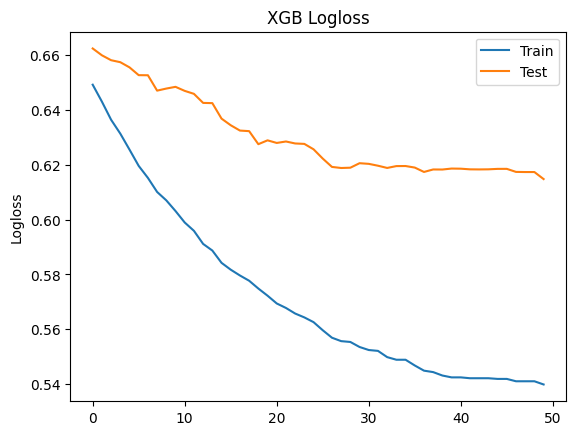

In [22]:
# Retrieve performance metrics
results = classifier.evals_result()

# Get the number of epochs
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# Plot Log Loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Logloss')
plt.title('XGB Logloss')
plt.show()

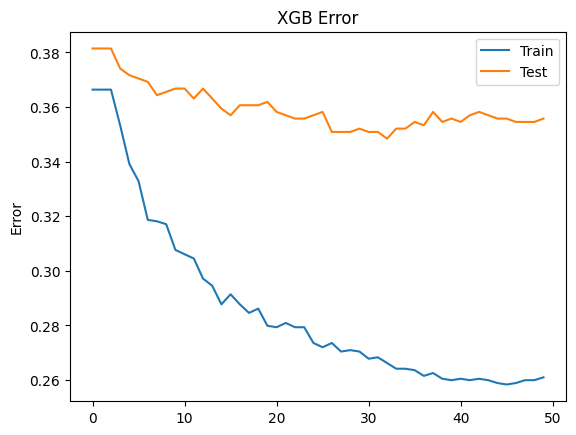

In [23]:
# Plot Error Rate
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGB Error')
plt.show()

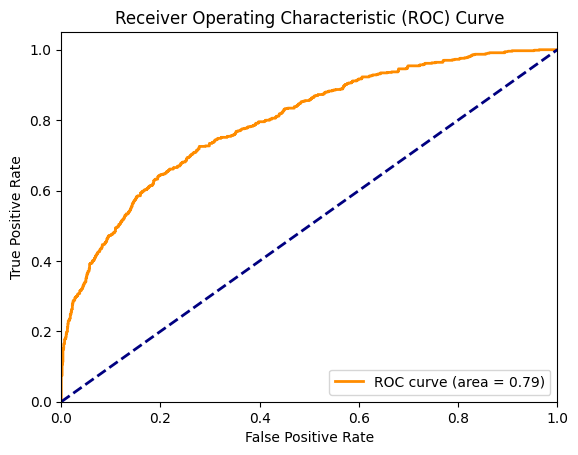

In [24]:
# Plot Training ROC Curve
plot_roc(classifier, X_train, y_train)

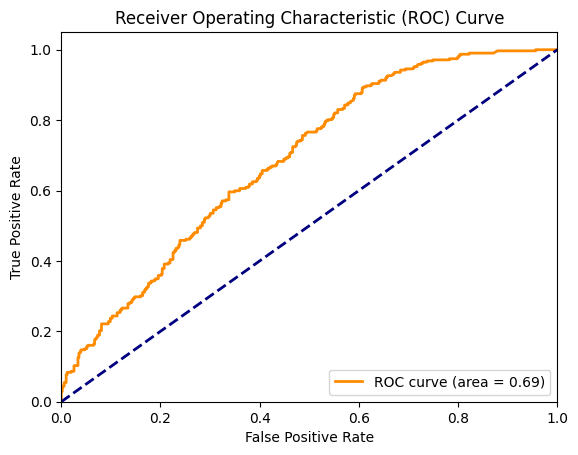

In [25]:
# Plot Training ROC Curve
plot_roc(classifier, X_test, y_test)

### Performance Evaluation Comparison

In [26]:
# Set k-fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [27]:
# Training and Test Results

# Perform cross-validation on the training data
train_results = cross_val_score(
    classifier,  # The trained classifier model
    X_train,     # Training features
    y_train,     # Training labels
    scoring=scoring,  # The scoring metric defined earlier (e.g., 'precision', 'f1', or 'accuracy')
    cv=cv,       # Cross-validation strategy (e.g., RepeatedStratifiedKFold)
    n_jobs=1    # Use all available CPU cores for parallel processing
)

# Perform cross-validation on the test data
test_results = cross_val_score(
    classifier,  # The same trained classifier model
    X_test,      # Test features
    y_test,      # Test labels
    scoring=scoring,  # The same scoring metric as used for training
    cv=cv,       # The same cross-validation strategy
    n_jobs=1    # Use all available CPU cores
)

# These results will give you arrays of scores for each fold of the cross-validation,
# allowing you to assess the model's performance and consistency across different subsets of the data.

* Changing `n_jobs=-1` to `n_jobs=1`:
   * `n_jobs=-1` means use all available CPU cores for parallel processing.
   * `n_jobs=1` means use only one core (no parallelization).
* Warning disappearance:
   * The warnings were likely related to parallel processing issues with XGBoost and the cross-validation function.
   * By using a single core, you've avoided these parallelization-related warnings.

Training set score: 0.689 (+/- 0.099)
Test set score: 0.568 (+/- 0.068)


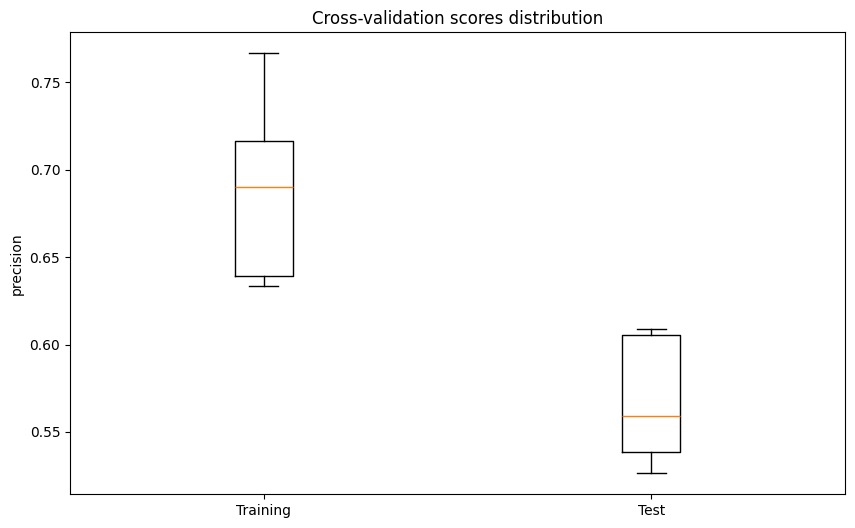

In [28]:
# Print mean and standard deviation of the scores
print("Training set score: %0.3f (+/- %0.3f)" % (train_results.mean(), train_results.std() * 2))
print("Test set score: %0.3f (+/- %0.3f)" % (test_results.mean(), test_results.std() * 2))

# Visualize the distribution of scores
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.boxplot([train_results, test_results], labels=['Training', 'Test'])
plt.title('Cross-validation scores distribution')
plt.ylabel(scoring)  # This will be 'Precision', 'F1', or 'Accuracy' based on your earlier choice
plt.show()

In [29]:
import numpy as np
from sklearn.metrics import precision_score

print("TRAIN:")
print(f"Average Acc K-Fold {train_results.mean():.2f}")
print(f"Std Dev K-Fold {train_results.std():.2f}")

# Calculate precision manually
def calculate_precision(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    predicted_positives = np.sum(y_pred == 1)
    return true_positives / predicted_positives if predicted_positives > 0 else 0

# y_train and train_yhat are already numpy arrays, so no conversion needed
print(f"Precision Score 0 {calculate_precision(y_train, train_yhat):.3f}")
print(f"Precision Score 1 {precision_score(y_train, train_yhat, average=None)[1]:.3f}")
print("----- ----- ----- ----- ----- -----")

print("TEST:")
print(f"Average Acc K-Fold {test_results.mean():.2f}")
print(f"Std Dev K-Fold {test_results.std():.2f}")

# y_test and test_yhat are already numpy arrays, so no conversion needed
print(f"Precision Score 0 {calculate_precision(y_test, test_yhat):.3f}")
print(f"Precision Score 1 {precision_score(y_test, test_yhat, average=None)[1]:.3f}")
print("")

TRAIN:
Average Acc K-Fold 0.69
Std Dev K-Fold 0.05
Precision Score 0 0.778
Precision Score 1 0.778
----- ----- ----- ----- ----- -----
TEST:
Average Acc K-Fold 0.57
Std Dev K-Fold 0.03
Precision Score 0 0.580
Precision Score 1 0.580



In [30]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def calculate_trading_metrics(y_true, y_pred):
    """
    Calculate trading-specific metrics for model evaluation.
    
    :param y_true: True labels (actual market movements)
    :param y_pred: Predicted labels (model's predictions)
    :return: Dictionary of metrics relevant to trading performance
    """
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    cm = confusion_matrix(y_true, y_pred)
    
    # Win rate: percentage of correctly predicted positive outcomes
    # In trading, this represents the proportion of profitable trades
    win_rate = precision[1] if np.sum(y_pred == 1) > 0 else 0
    
    # Coverage: proportion of times the model decides to trade
    # Helps balance between being selective and maintaining trading volume
    coverage = np.mean(y_pred == 1)
    
    # Profit Factor: ratio of gross profit to gross loss
    # A key profitability metric in trading
    true_positives = cm[1, 1]
    false_positives = cm[0, 1]
    profit_factor = true_positives / false_positives if false_positives > 0 else np.inf
    
    return {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Win Rate': win_rate,
        'Coverage': coverage,
        'Profit Factor': profit_factor
    }

# Evaluate model performance on both training and test sets
for dataset_name, y_true, y_pred in [('TRAIN', y_train, train_yhat), ('TEST', y_test, test_yhat)]:
    print(f"{dataset_name}:")
    
    # K-fold cross-validation results
    print(f"Average Acc K-Fold {train_results.mean():.2f}")  # Overall predictive power
    print(f"Std Dev K-Fold {train_results.std():.2f}")  # Consistency across different market conditions
    
    metrics = calculate_trading_metrics(y_true, y_pred)
    
    # Precision: Accuracy of positive predictions
    # In trading: How often the model correctly predicts profitable trades
    print(f"Precision: {metrics['Precision']}")
    
    # Recall: Proportion of actual positives correctly identified
    # In trading: How many of the actually profitable trades the model caught
    print(f"Recall: {metrics['Recall']}")
    
    # F1 Score: Harmonic mean of precision and recall
    # Balances the trade-off between making profitable trades and catching all opportunities
    print(f"F1 Score: {metrics['F1 Score']}")
    
    # Win Rate: Proportion of trades that are profitable
    # Crucial for understanding the success rate of the trading strategy
    print(f"Win Rate: {metrics['Win Rate']:.3f}")
    
    # Coverage: Proportion of potential trades the model acts on
    # Helps balance between being selective and maintaining sufficient trading volume
    print(f"Coverage: {metrics['Coverage']:.3f}")
    
    # Profit Factor: Ratio of gross profit to gross loss
    # Key profitability metric; values > 1 indicate a profitable system
    print(f"Profit Factor: {metrics['Profit Factor']:.3f}")
    
    print("----- ----- ----- ----- ----- -----")

print("")

# Note: In real trading scenarios, consider additional metrics like:
# - Sharpe Ratio: Risk-adjusted return
# - Maximum Drawdown: Largest peak-to-trough decline
# - Transaction costs: To ensure profitability after fees

# TODO: Visualize confusion matrix to understand error types
# TODO: Analyze feature importance to identify key market indicators
# TODO: Visualize decision tree to understand the model's decision process

TRAIN:
Average Acc K-Fold 0.69
Std Dev K-Fold 0.05
Precision: [0.72979961 0.77839335]
Recall: [0.93382961 0.40200286]
F1 Score: [0.81930334 0.53018868]
Win Rate: 0.778
Coverage: 0.189
Profit Factor: 3.513
----- ----- ----- ----- ----- -----
TEST:
Average Acc K-Fold 0.69
Std Dev K-Fold 0.05
Precision: [0.65647744 0.58015267]
Recall: [0.89130435 0.24358974]
F1 Score: [0.75607712 0.34311512]
Win Rate: 0.580
Coverage: 0.160
Profit Factor: 1.382
----- ----- ----- ----- ----- -----



### Evaluation Metrics - Summary Report

In [31]:
from sklearn.metrics import classification_report

# Show summary report - Training
print("# Show summary report - Training")
print(classification_report(y_train, train_yhat))

# Show summary report - Test
print("\n# Show summary report - Test")
print(classification_report(y_test, test_yhat))

# Show summary report - Training
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      1209
           1       0.78      0.40      0.53       699

    accuracy                           0.74      1908
   macro avg       0.75      0.67      0.67      1908
weighted avg       0.75      0.74      0.71      1908


# Show summary report - Test
              precision    recall  f1-score   support

           0       0.66      0.89      0.76       506
           1       0.58      0.24      0.34       312

    accuracy                           0.64       818
   macro avg       0.62      0.57      0.55       818
weighted avg       0.63      0.64      0.60       818



In [32]:
import polars as pl
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def generate_rounded_report(y_true, y_pred):
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    df = pl.DataFrame({
        'class': ['0.0', '1.0', 'accuracy', 'macro avg', 'weighted avg'],
        'precision': [precision[0], precision[1], None, 
                      precision.mean(), (precision * support).sum() / support.sum()],
        'recall': [recall[0], recall[1], None, 
                   recall.mean(), (recall * support).sum() / support.sum()],
        'f1-score': [f1[0], f1[1], accuracy, 
                     f1.mean(), (f1 * support).sum() / support.sum()],
        'support': support.tolist() + [support.sum()] * 3
    })

    # Round numeric columns to 3 decimal places
    for col in ['precision', 'recall', 'f1-score']:
        df = df.with_columns(pl.col(col).round(3))

    return df

# Show summary report - Training
print("# Show summary report - Training")
train_report = generate_rounded_report(y_train, train_yhat)
print(train_report)

print("\n# Show summary report - Test")
test_report = generate_rounded_report(y_test, test_yhat)
print(test_report)

# Show summary report - Training
shape: (5, 5)
┌──────────────┬───────────┬────────┬──────────┬─────────┐
│ class        ┆ precision ┆ recall ┆ f1-score ┆ support │
│ ---          ┆ ---       ┆ ---    ┆ ---      ┆ ---     │
│ str          ┆ f64       ┆ f64    ┆ f64      ┆ i64     │
╞══════════════╪═══════════╪════════╪══════════╪═════════╡
│ 0.0          ┆ 0.73      ┆ 0.934  ┆ 0.819    ┆ 1209    │
│ 1.0          ┆ 0.778     ┆ 0.402  ┆ 0.53     ┆ 699     │
│ accuracy     ┆ null      ┆ null   ┆ 0.739    ┆ 1908    │
│ macro avg    ┆ 0.754     ┆ 0.668  ┆ 0.675    ┆ 1908    │
│ weighted avg ┆ 0.748     ┆ 0.739  ┆ 0.713    ┆ 1908    │
└──────────────┴───────────┴────────┴──────────┴─────────┘

# Show summary report - Test
shape: (5, 5)
┌──────────────┬───────────┬────────┬──────────┬─────────┐
│ class        ┆ precision ┆ recall ┆ f1-score ┆ support │
│ ---          ┆ ---       ┆ ---    ┆ ---      ┆ ---     │
│ str          ┆ f64       ┆ f64    ┆ f64      ┆ i64     │
╞══════════════╪════════

### Performance Evaluation - COnfusion Matrix

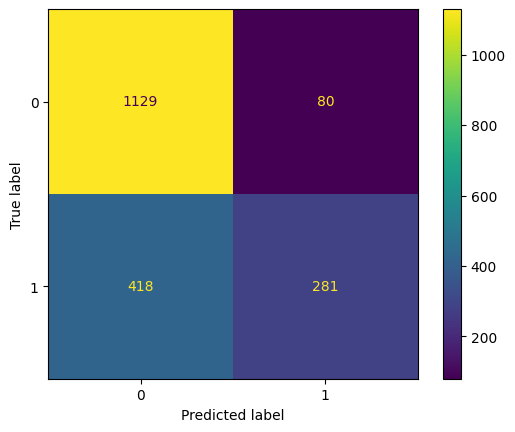

In [33]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, train_yhat)
ConfusionMatrixDisplay(cm_train).plot()

# Confusion Matrix Analysis

Let's analyze the confusion matrix for our training data:


## Understanding the Matrix

The confusion matrix shows:
- True label on the y-axis
- Predicted label on the x-axis
- 0: Size of move same or below average
- 1: Size of move above average

## Results Breakdown

1. True Positives (Actual 1, Predicted 1): 281
2. False Negatives (Actual 1, Predicted 0): 418
3. True Negatives (Actual 0, Predicted 0): 1129
4. False Positives (Actual 0, Predicted 1): 80

## Observations

1. **Bias towards predicting 0**: The model seems to favor predicting 0 (move same or below average) more often.
   - This explains the high recall for class 0.

2. **Imbalanced predictions**: 
   - Correctly predicted 0: 1129 times
   - Correctly predicted 1: 281 times
   This suggests a significant imbalance in the dataset or model's performance.

3. **Misclassifications**:
   - 418 instances where the model predicted 0 when it was actually 1
   - Only 80 instances where it predicted 1 when it was actually 0
   This further confirms the model's bias towards predicting 0.

## Potential Improvements

1. **Data balancing**: Consider techniques to balance the dataset if it's imbalanced.
2. **Feature engineering**: Explore creating new features or transforming existing ones to better capture the patterns leading to class 1.
3. **Model tuning**: Adjust model parameters to reduce bias towards class 0.
4. **Ensemble methods**: Combine multiple models to improve overall prediction accuracy.
5. **Time series considerations**: If this is time series data, consider incorporating temporal features or using time series specific models.

## Next Steps

1. Analyze the test set confusion matrix to confirm if these patterns persist.
2. Investigate feature importance to understand which factors most influence the predictions.
3. Consider incorporating hidden Markov models to capture regime changes, which could improve predictions across different market conditions.

# Enhancing Predictions with Markov Models for Market Regimes

## Why Markov Models for Market Regimes?

1. **Capture State Transitions**: Markov models excel at modeling systems that transition between different states, which aligns well with the concept of market regimes.

2. **Incorporate Time Dependency**: Unlike our current model, a Markov model can capture the temporal dependencies in market behavior.

3. **Adaptive Predictions**: By identifying the current regime, we can adjust our predictions for market moves accordingly.

## Proposed Enhanced System

1. **Regime Identification Model**:
   - Implement a Hidden Markov Model (HMM) to identify market regimes.
   - Potential regimes: Bull market, Bear market, High volatility, Low volatility, etc.

2. **Regime-Specific Prediction Models**:
   - Train separate models for predicting market moves within each identified regime.
   - This allows for more specialized and accurate predictions based on the current market context.

3. **Combined Prediction System**:

In [34]:
# Input Data -> HMM Regime Identifier -> Select Appropriate Model -> Make Prediction

## Expected Improvements

1. **Increased Accuracy**: By using regime-specific models, we can capture nuances that a single model might miss.

2. **Better Handling of Market Shifts**: The system can adapt quickly to changing market conditions.

3. **Reduced False Positives/Negatives**: Each regime-specific model can be optimized to reduce errors common in that particular market state.

4. **Improved Interpretability**: Knowing the predicted regime provides additional context for understanding model decisions.

## Implementation Considerations

1. **Data Requirements**: Ensure sufficient historical data to train both the HMM and regime-specific models.

2. **Feature Engineering**: Develop features that are indicative of regime changes (e.g., volatility indices, moving averages, economic indicators).

3. **Model Selection**: Choose appropriate models for each regime (e.g., linear models for stable regimes, more complex models for volatile periods).

4. **Backtesting**: Rigorously backtest the combined system to ensure it outperforms the single-model approach.

5. **Continuous Learning**: Implement a system to periodically retrain models to adapt to evolving market dynamics.

## Potential Challenges

1. **Complexity**: The multi-model system is more complex to maintain and interpret.

2. **Regime Transition Lags**: There might be a delay in identifying regime changes, affecting short-term predictions.

3. **Data Sparsity**: Some regimes might have limited historical data, making model training challenging.

## Next Steps

1. Implement a basic HMM to identify market regimes using historical data.
2. Analyze the confusion matrix for each identified regime to understand prediction patterns.
3. Develop and test regime-specific prediction models.
4. Compare the performance of the new system against our current single-model approach.

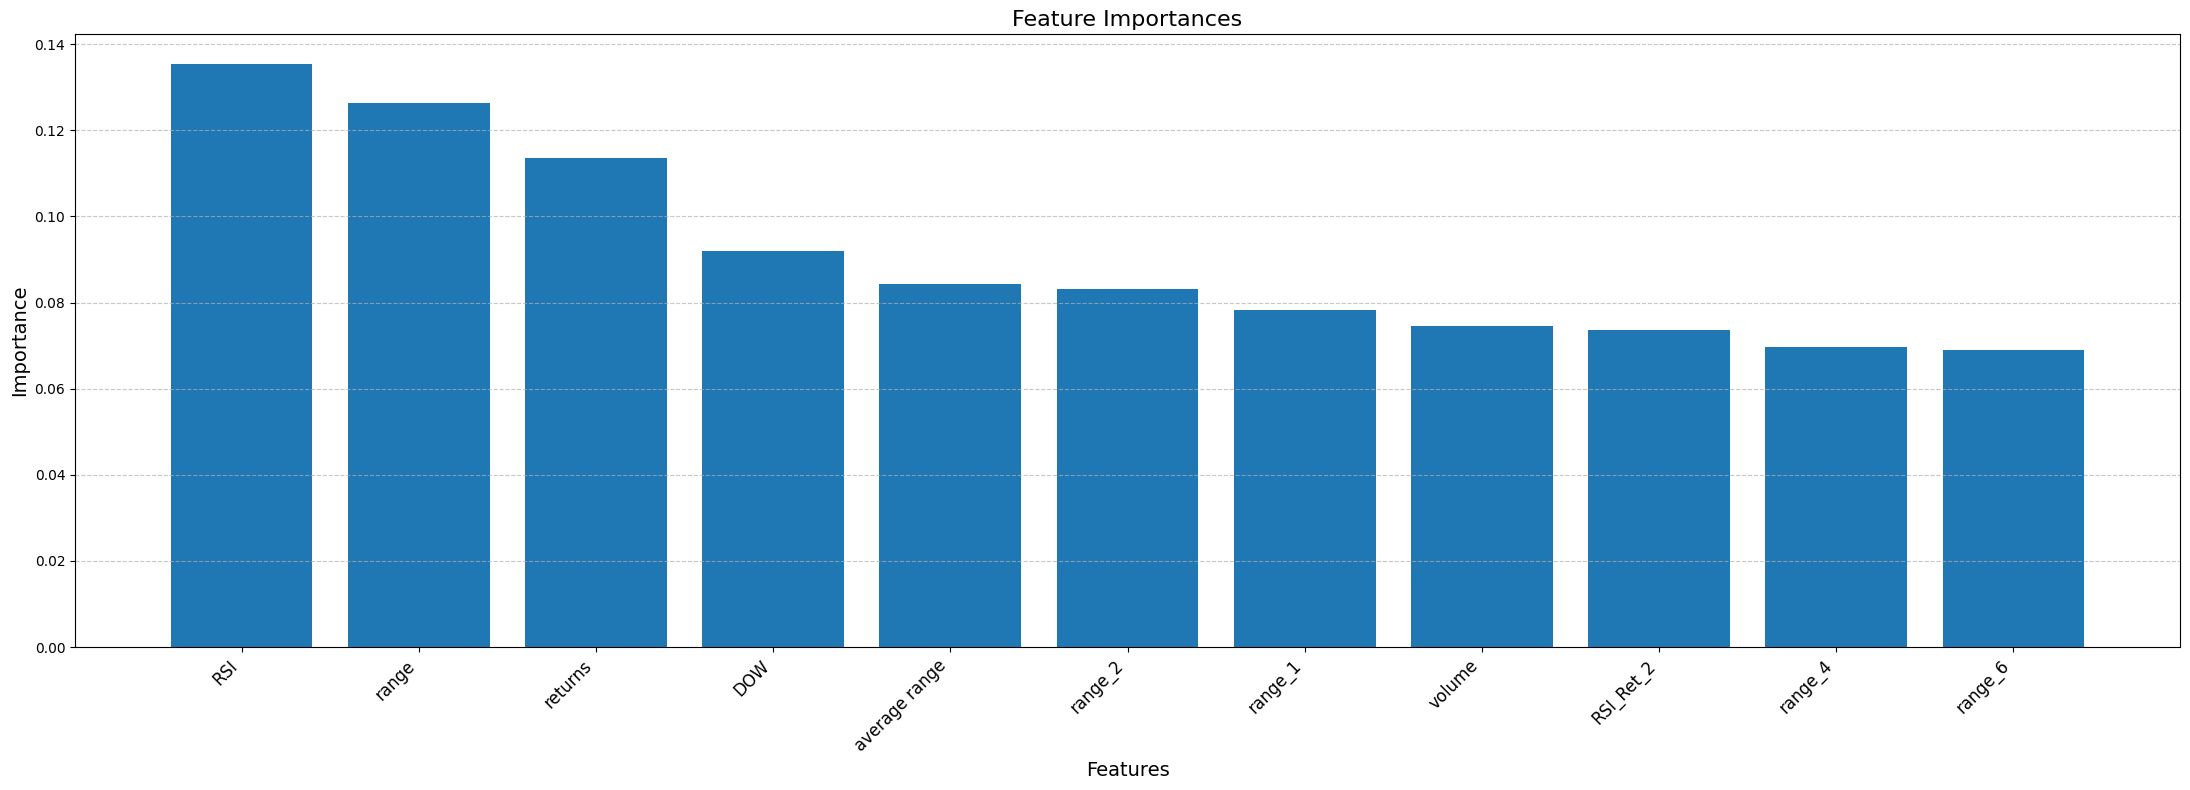

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'classifier' is your trained model and 'X' is your feature numpy array

# Get feature importances and sort them
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]

# Create the plot
fig, ax = plt.subplots(figsize=(22, 8))  # Increased height for better label visibility

# Plot the bar chart
ax.bar(range(X.shape[1]), importances[indices])

# Customize the plot
ax.set_ylabel('Importance', fontsize=14)
ax.set_xlabel('Features', fontsize=14)
ax.set_title('Feature Importances', fontsize=16)

# Set x-axis ticks and labels
ax.set_xticks(range(X.shape[1]))
ax.set_xticklabels([feature_columns[i] for i in indices], rotation=45, ha='right', fontsize=12)

# Add grid in the background
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

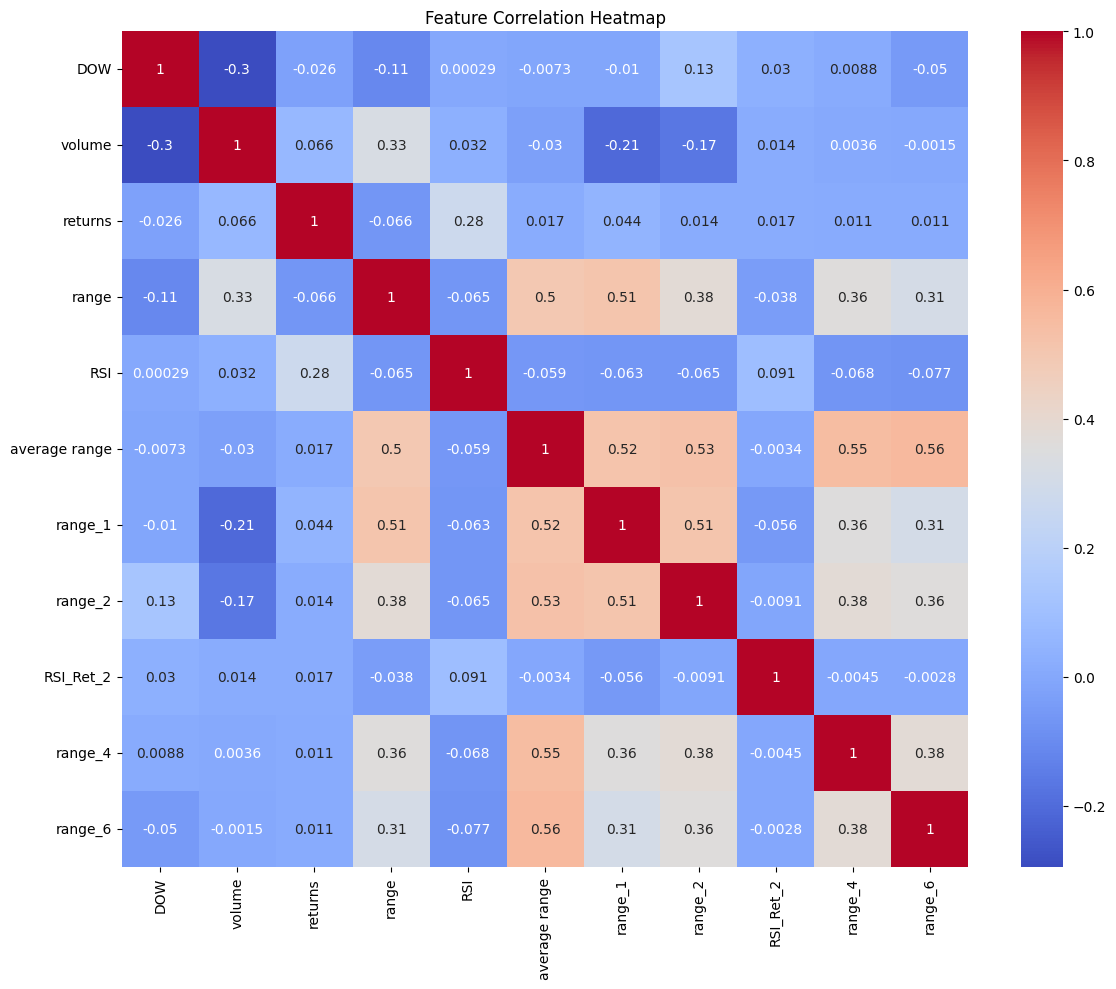

In [36]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = np.corrcoef(X.T)

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=feature_columns, yticklabels=feature_columns)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

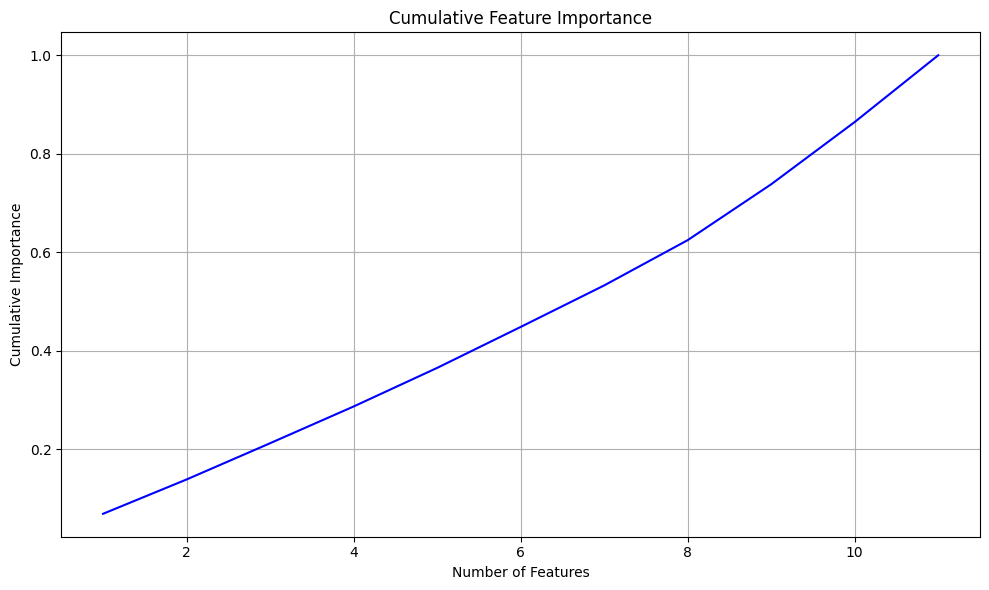

'Cumulative Feature Importance:\nThis can show how many features are needed to capture a certain percentage of the total importance.'

In [37]:
# Sort features by importance
sorted_idx = np.argsort(importances)
sorted_features = [feature_columns[i] for i in sorted_idx]

# Calculate cumulative importance
cumulative_importance = np.cumsum(importances[sorted_idx])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_features) + 1), cumulative_importance, 'b-')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid(True)
plt.tight_layout()
plt.show()
'''Cumulative Feature Importance:
This can show how many features are needed to capture a certain percentage of the total importance.''' 

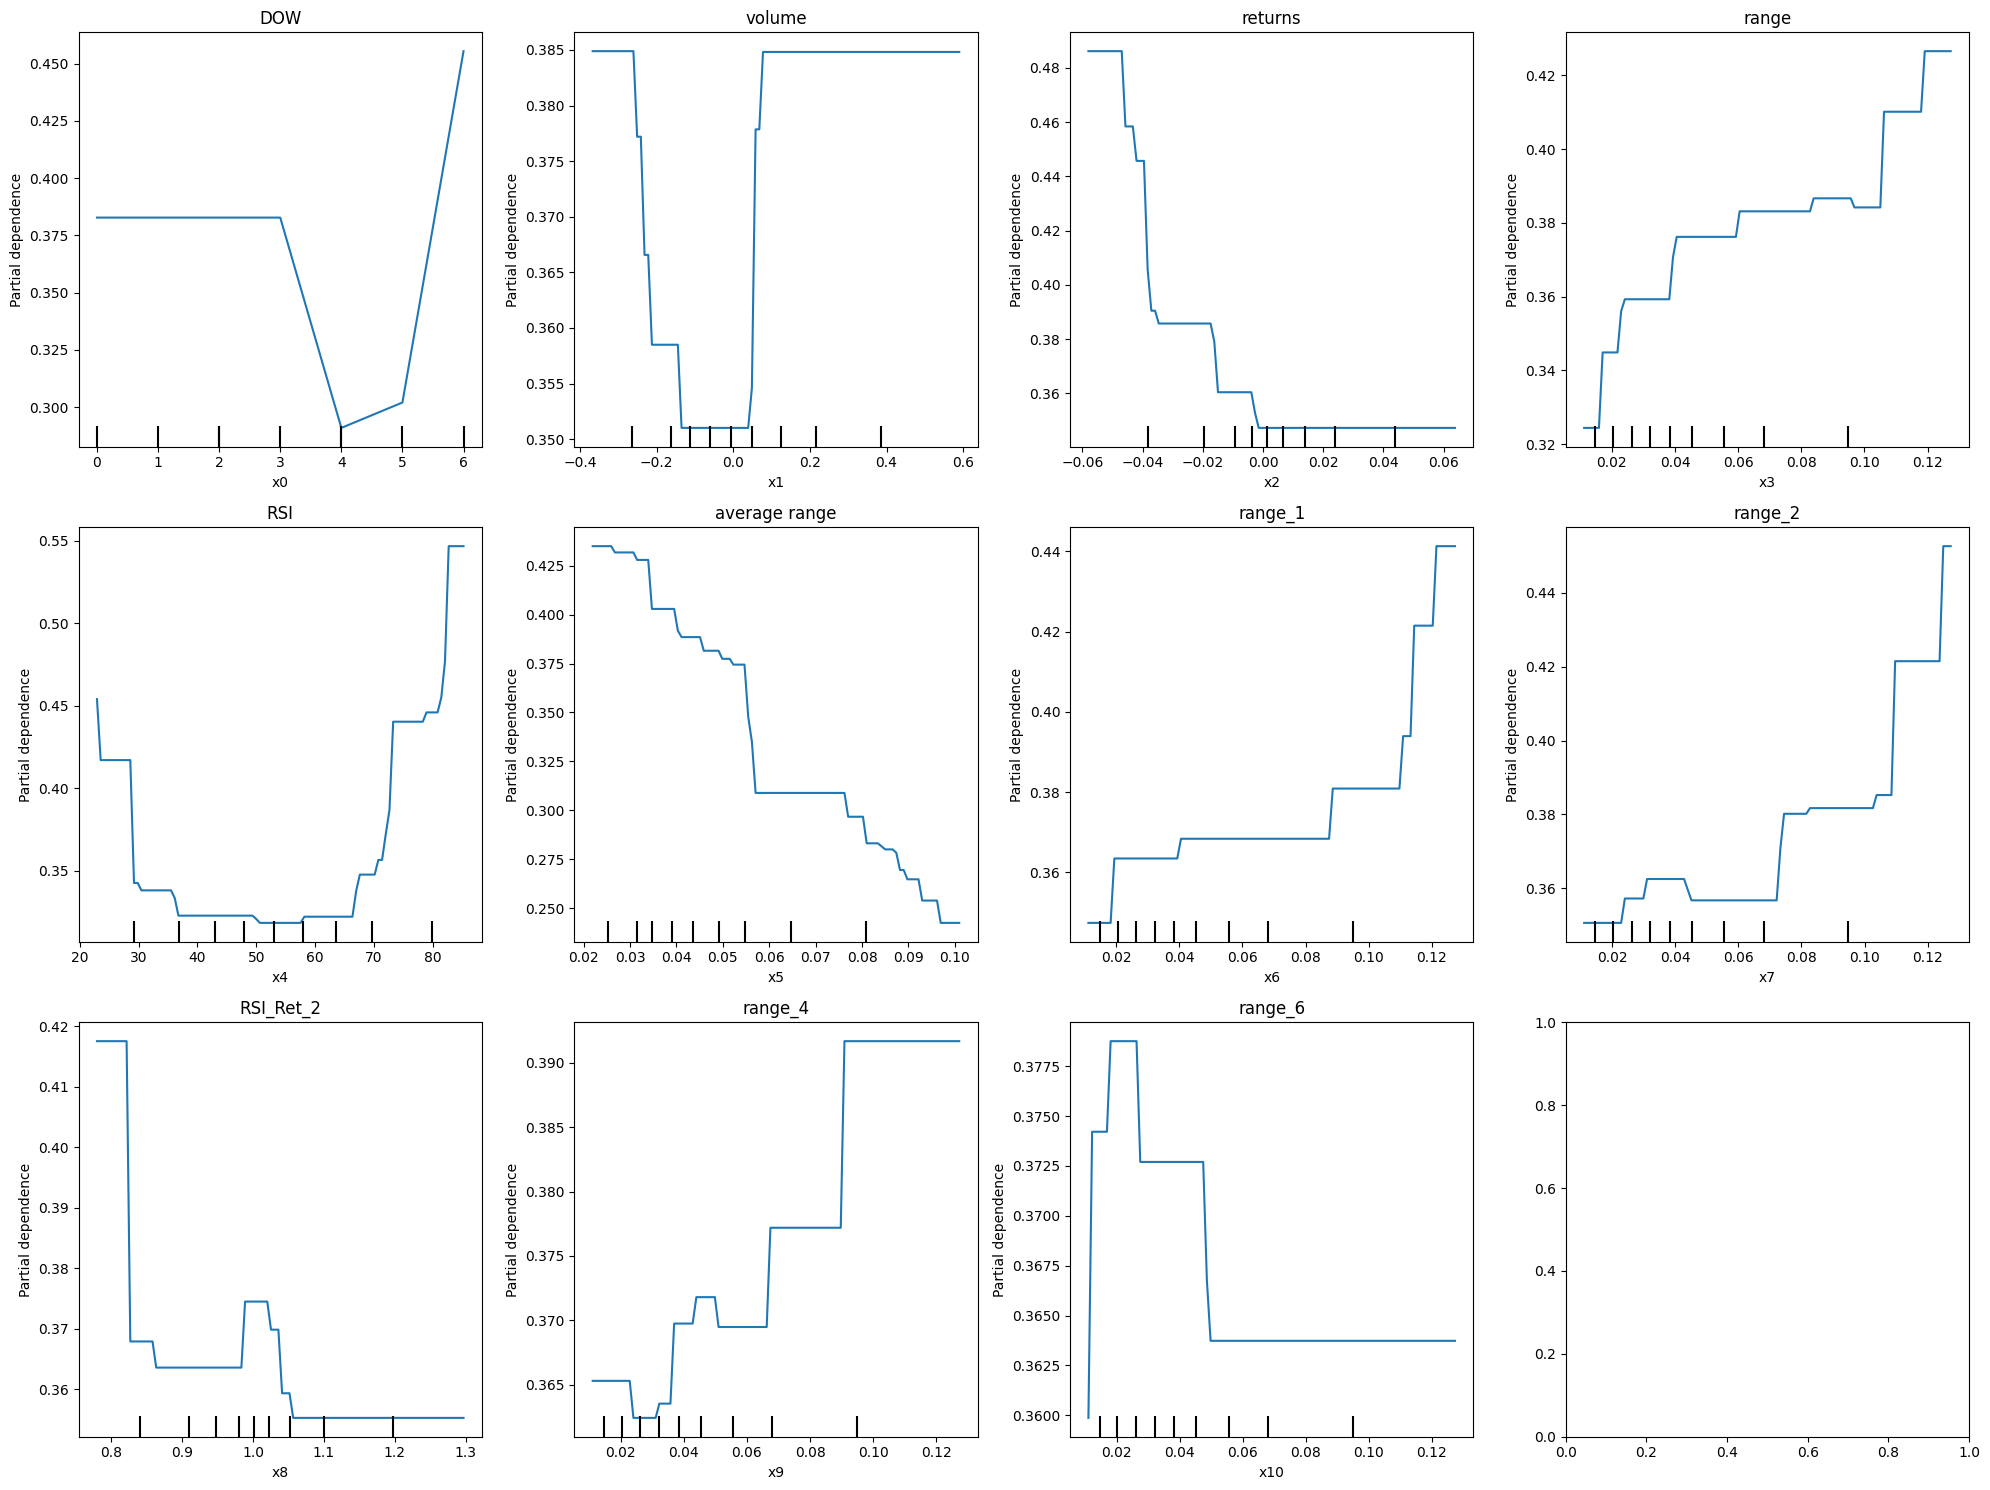

" Partial Dependence Plots:\nThese show how the model's predictions change as we vary each feature."

In [38]:
from sklearn.inspection import PartialDependenceDisplay

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()

for i, feature in enumerate(feature_columns):
    PartialDependenceDisplay.from_estimator(classifier, X, [i], ax=axes[i])
    axes[i].set_title(feature)

plt.tight_layout()
plt.show()
''' Partial Dependence Plots:
These show how the model's predictions change as we vary each feature.'''

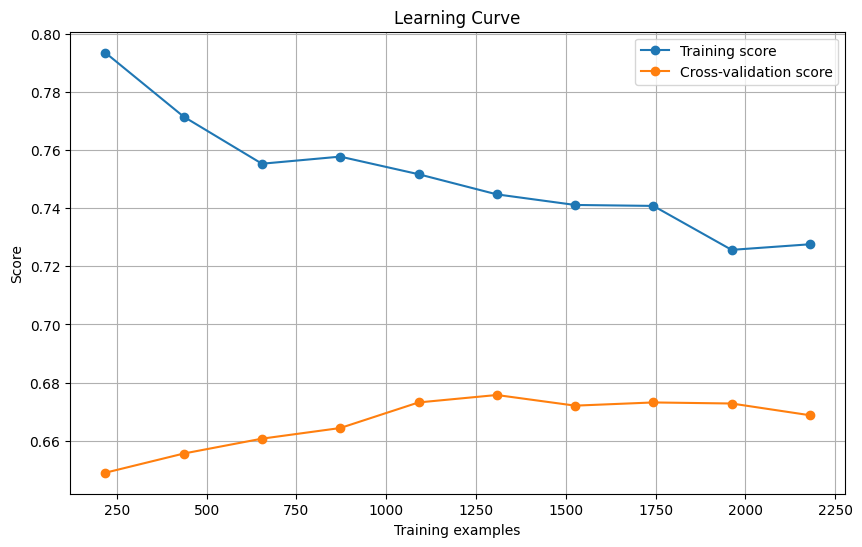

In [39]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    classifier, X, y, cv=5, n_jobs=1, 
    train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

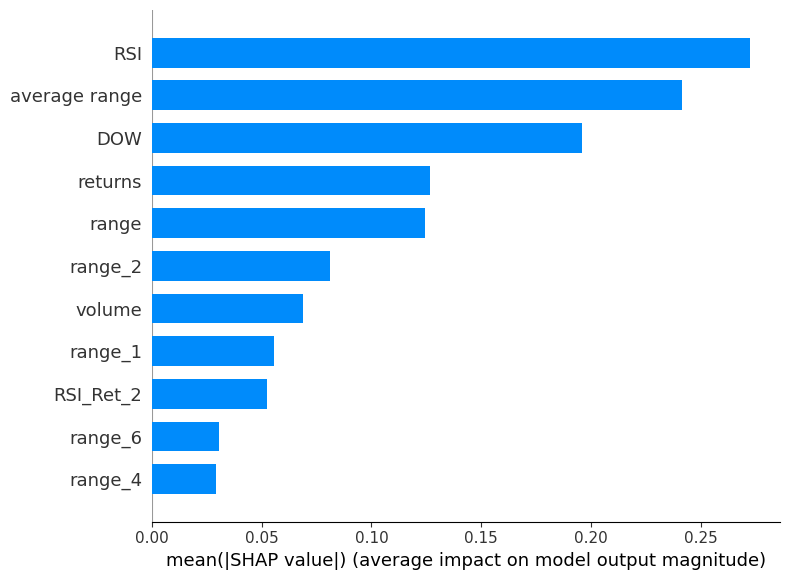

<Figure size 640x480 with 0 Axes>

In [40]:
import shap

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X, plot_type="bar", feature_names=feature_columns)
plt.tight_layout()
plt.show()

SHAP (SHapley Additive exPlanations) is a powerful library for model interpretability, but it's not included in the standard Python distribution or most data science packages by default.

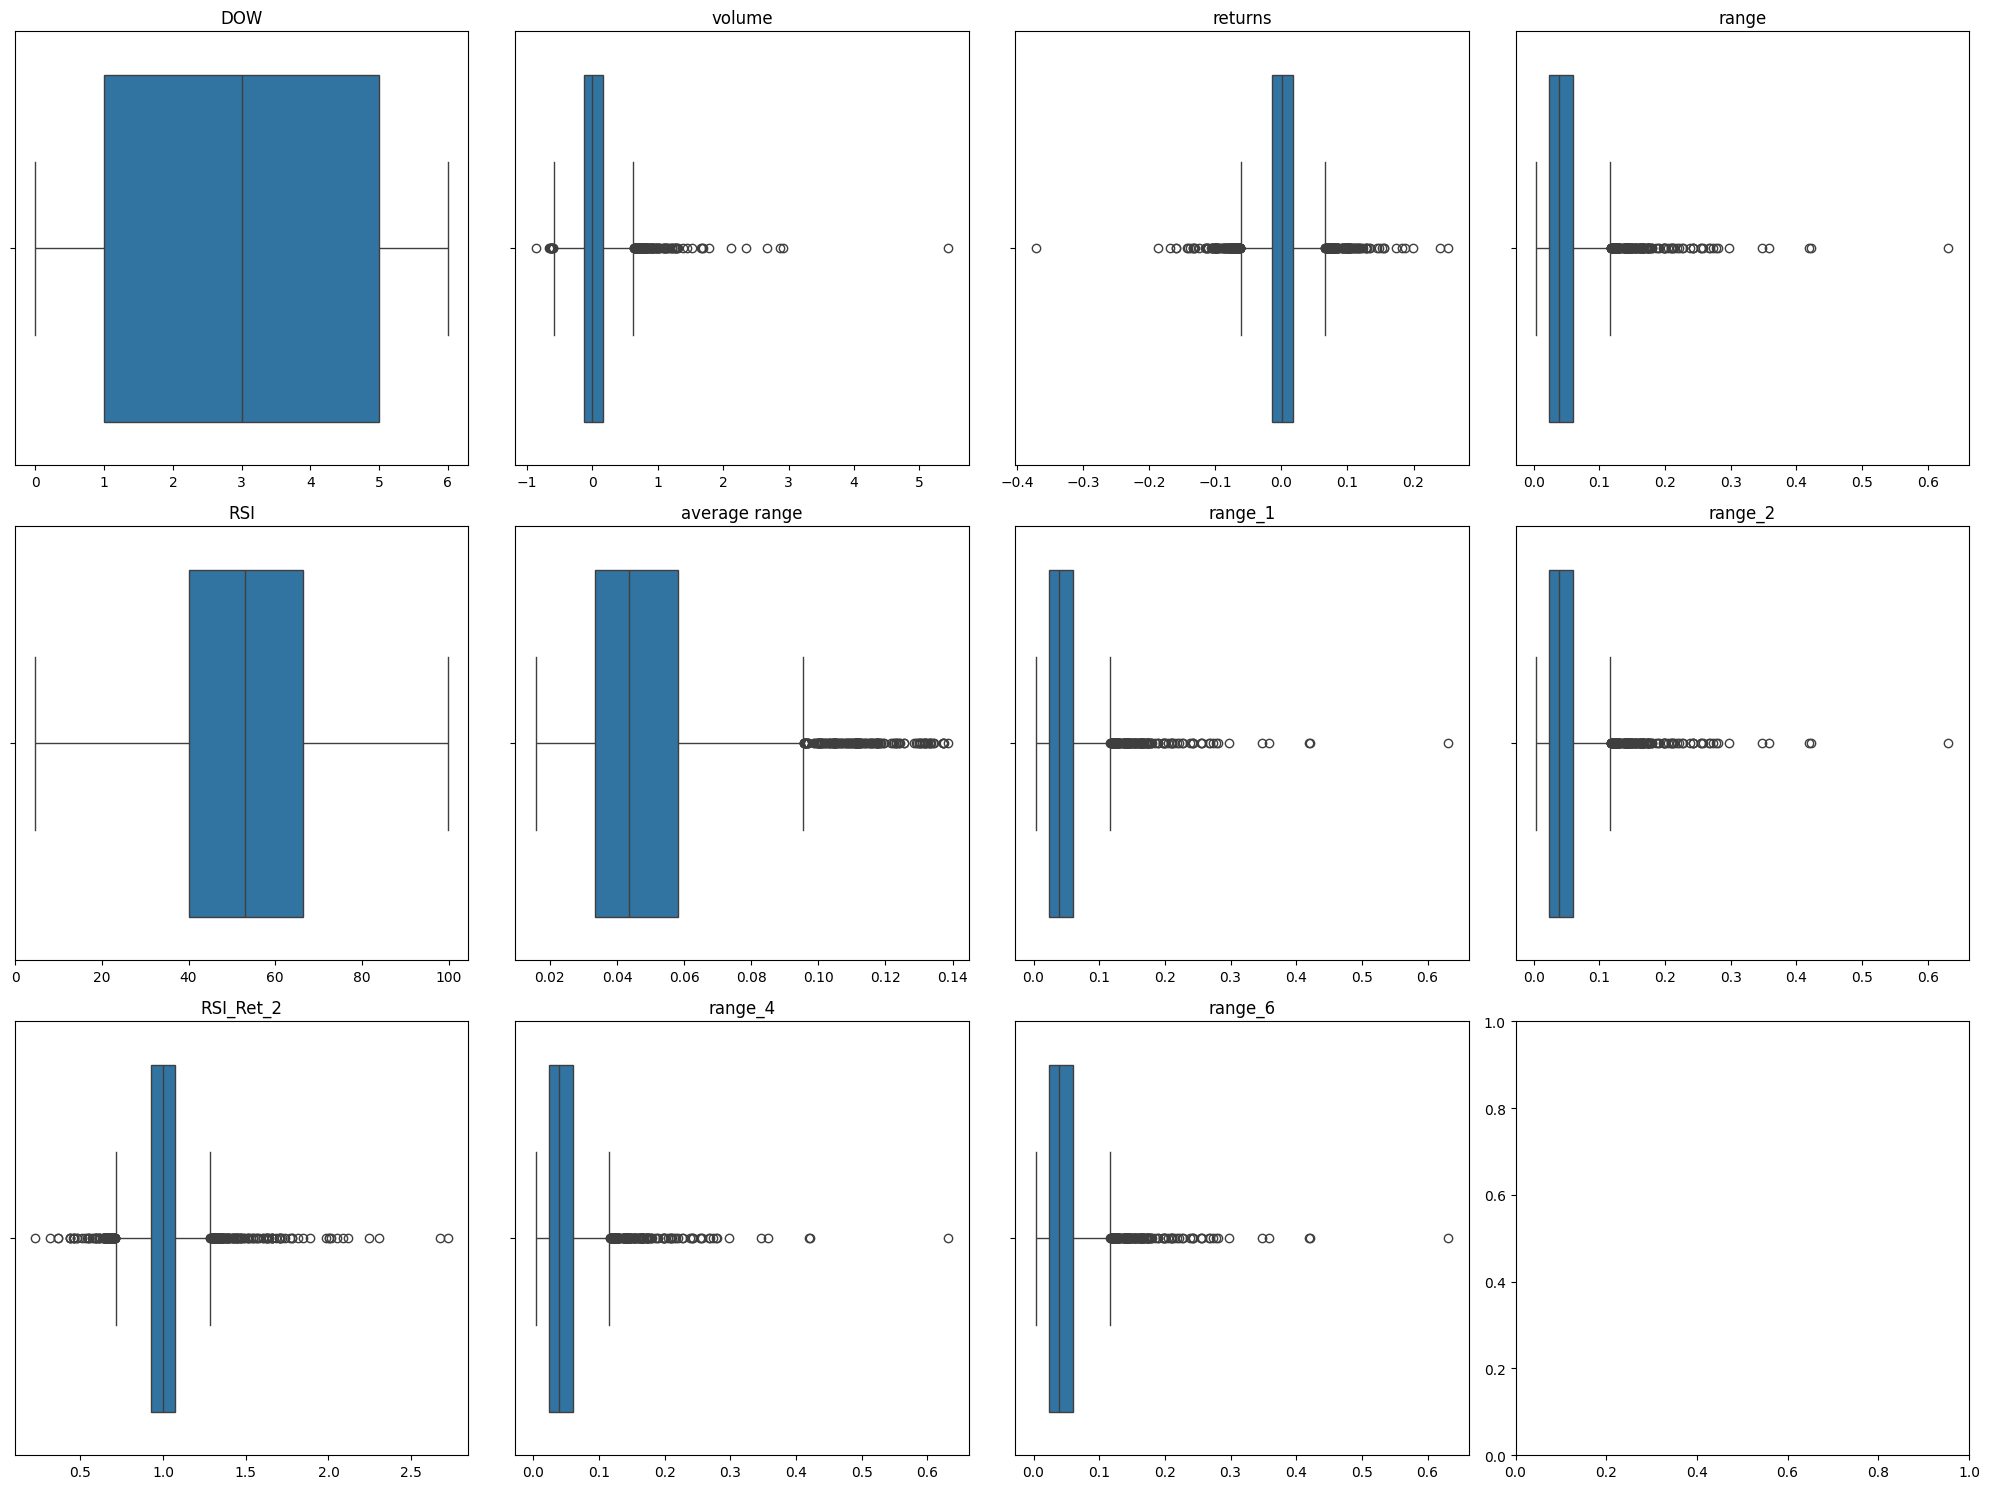

' Boxplots for Feature Distributions:\nThis can help you understand the distribution of each feature.'

In [41]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()

for i, feature in enumerate(feature_columns):
    sns.boxplot(x=X[:, i], ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()
''' Boxplots for Feature Distributions:
This can help you understand the distribution of each feature.'''

### XGBOOST Tree

In [50]:
# Hyperparameters
ne = 80  # Number of estimators
lr = 0.01  # Learning rate
md = 3  # Max depth
gm = 6  # Gamma

# Feature names
feature_names = [
    "DOW", "volume", "returns", "range", "RSI", "average range", 
    "range_1", "range_2", "RSI_Ret_2", "range_4", "range_6"
]

# XGBOOST Classifier
classifier = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

# Prepare evaluation set
eval_set = [(X_train, y_train), (X_test, y_test)]

# Fit the classifier
classifier.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)

# Set the feature names in the booster
classifier.get_booster().feature_names = feature_names

# Print the classifier
print(classifier)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=6,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=80, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)


## Understanding XGBoost's Booster Object

The `.get_booster()` method in XGBoost returns the underlying booster object, providing low-level access to the model's internals. Here are some key methods and properties:

### Key Methods and Properties of the Booster Object

1. **`feature_names`**
   - Property to get or set feature names used by the model.
   - Usage: `booster.feature_names = ['feature1', 'feature2', ...]`

2. **`get_dump()`**
   - Returns a list of strings representing each tree in the model.
   - Usage: `tree_dump = booster.get_dump()`

3. **`get_score(importance_type='weight')`**
   - Retrieves feature importance scores.
   - `importance_type` can be 'weight', 'gain', or 'cover'.
   - Usage: `importance_scores = booster.get_score(importance_type='gain')`

4. **`save_model(fname)` and `load_model(fname)`**
   - Methods to save and load the model.
   - Usage:
     ```python
     booster.save_model('my_model.json')
     loaded_booster = xgb.Booster()
     loaded_booster.load_model('my_model.json')
     ```

5. **`predict(data)`**
   - Makes predictions on new data.
   - Usage: `predictions = booster.predict(new_data)`

6. **`num_boosted_rounds()`**
   - Returns the number of boosted trees.
   - Usage: `n_trees = booster.num_boosted_rounds()`

7. **`num_features()`**
   - Returns the number of features used in the model.
   - Usage: `n_features = booster.num_features()`

8. **`attributes`**
   - Dictionary of attributes set during training.
   - Usage: `attrs = booster.attributes`

9. **`set_param(params)`**
   - Updates parameters of the booster.
   - Usage: `booster.set_param({'max_depth': 5})`

10. **`feature_types`**
    - Gets or sets the feature types (e.g., 'float', 'int', 'i').
    - Usage: `booster.feature_types = ['float', 'int', ...]`

11. **`copy()`**
    - Creates a deep copy of the booster.
    - Usage: `new_booster = booster.copy()`

12. **`get_fscore()`**
    - Older method to get feature importance scores (consider using `get_score()` instead).
    - Usage: `fscores = booster.get_fscore()`

### Advanced Methods

13. **`get_split_value_histogram(feature, fmap='', bins=None, as_pandas=True)`**
    - Returns a split value histogram for a feature.
    - Useful for understanding how a feature is used in splits across trees.

14. **`trees_to_dataframe()`**
    - Converts the model's trees into a pandas DataFrame.
    - Provides a detailed view of each node in each tree.

15. **`inplace_predict(data, ...)`**
    - Makes predictions in-place, which can be faster for certain data formats.

### Why These Methods Matter

- **Interpretability**: Methods like `get_dump()`, `get_score()`, and `get_split_value_histogram()` provide deep insights into the model's structure and decision-making process.
- **Flexibility**: Features like `set_param()` and `feature_types` allow for fine-tuning and proper data handling.
- **Performance Analysis**: `num_boosted_rounds()` and `num_features()` help in understanding model complexity.
- **Advanced Analysis**: `trees_to_dataframe()` enables detailed examination of the model structure.

By leveraging these methods, data scientists can gain deeper insights, enhance model interpretability, and have greater control over their XGBoost models throughout the development and deployment process.

<Figure size 2000x1000 with 0 Axes>

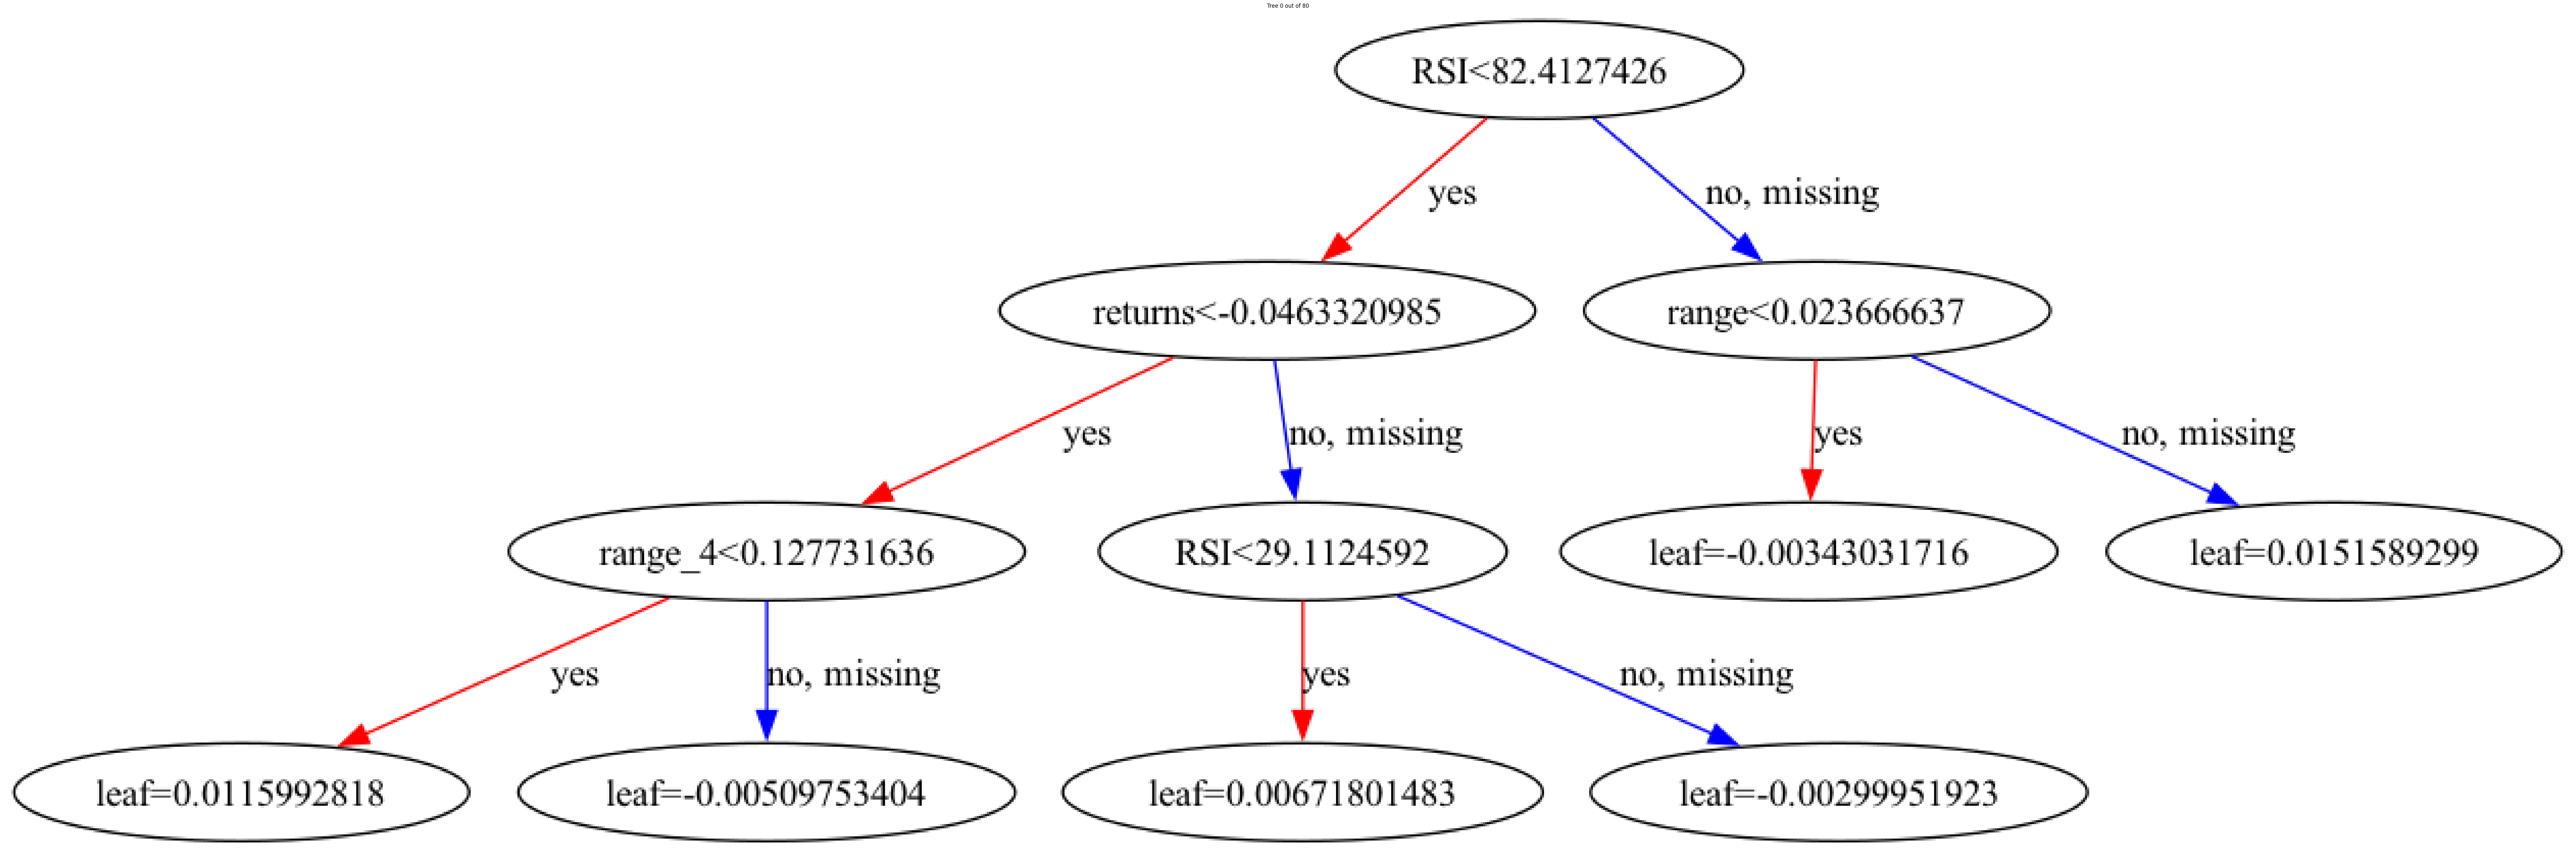

In [51]:
import matplotlib.pyplot as plt
from xgboost import plot_tree

# Get the number of trees in the model
n_trees = len(classifier.get_booster().get_dump())

# Plot the first tree (you can change the index to visualize different trees)
plt.figure(figsize=(20, 10))
plot_tree(classifier, num_trees=0, feature_names=feature_names)
plt.title(f"Tree 0 out of {n_trees}")
plt.tight_layout()
plt.show()

In [52]:
import numpy as np

# Create a copy of X_test
X_test_mod = np.copy(X_test)

# Get column indices for RSI, range, and returns
rsi_index = feature_columns.index("RSI")
range_index = feature_columns.index("range")
returns_index = feature_columns.index("returns")

# Modify RSI
X_test_mod[:, rsi_index] = np.where(X_test_mod[:, rsi_index] <= 80,
                                    X_test_mod[:, rsi_index] * 1.10,
                                    X_test_mod[:, rsi_index] * 1.05)

# Modify Range
X_test_mod[:, range_index] *= 0.85

# Modify Returns
X_test_mod[:, returns_index] = np.where(X_test_mod[:, returns_index] > 0,
                                        X_test_mod[:, returns_index] * 1.2,
                                        X_test_mod[:, returns_index] * 0.8)

# Make predictions
original_preds = classifier.predict(X_test)
mod_preds = classifier.predict(X_test_mod)

# Compare predictions
different = (original_preds != mod_preds).sum()
total = len(original_preds)
print(f"Modified data changed {different} out of {total} predictions ({different/total*100:.2f}%)")

# Show some examples where predictions changed
changed_indices = np.where(original_preds != mod_preds)[0]
for i in changed_indices[:5]:  # Show first 5 changed predictions
    print(f"\nExample {i}:")
    print("Original:")
    for j, feature in enumerate(feature_columns):
        print(f"{feature}: {X_test[i, j]}")
    print(f"Original prediction: {original_preds[i]}")
    print("\nModified:")
    for j, feature in enumerate(feature_columns):
        print(f"{feature}: {X_test_mod[i, j]}")
    print(f"Modified prediction: {mod_preds[i]}")
    print("-" * 50)

Modified data changed 28 out of 818 predictions (3.42%)

Example 16:
Original:
DOW: 0.0
volume: 0.7233474617280385
returns: -0.11046369999353145
range: 0.1295549779397165
RSI: 23.257946983171863
average range: 0.04336433636326711
range_1: 0.04793465709444744
range_2: 0.03403186928435131
RSI_Ret_2: 0.9807180129816966
range_4: 0.10968064120145526
range_6: 0.027786556922792638
Original prediction: 1

Modified:
DOW: 0.0
volume: 0.7233474617280385
returns: -0.08837095999482517
range: 0.11012173124875901
RSI: 25.58374168148905
average range: 0.04336433636326711
range_1: 0.04793465709444744
range_2: 0.03403186928435131
RSI_Ret_2: 0.9807180129816966
range_4: 0.10968064120145526
range_6: 0.027786556922792638
Modified prediction: 0
--------------------------------------------------

Example 19:
Original:
DOW: 3.0
volume: -0.04829859082793367
returns: 0.003849706798608521
range: 0.1397298185347151
RSI: 20.081544019224523
average range: 0.050822141216746546
range_1: 0.13641930405154112
range_2: 0.

<Figure size 2000x1000 with 0 Axes>

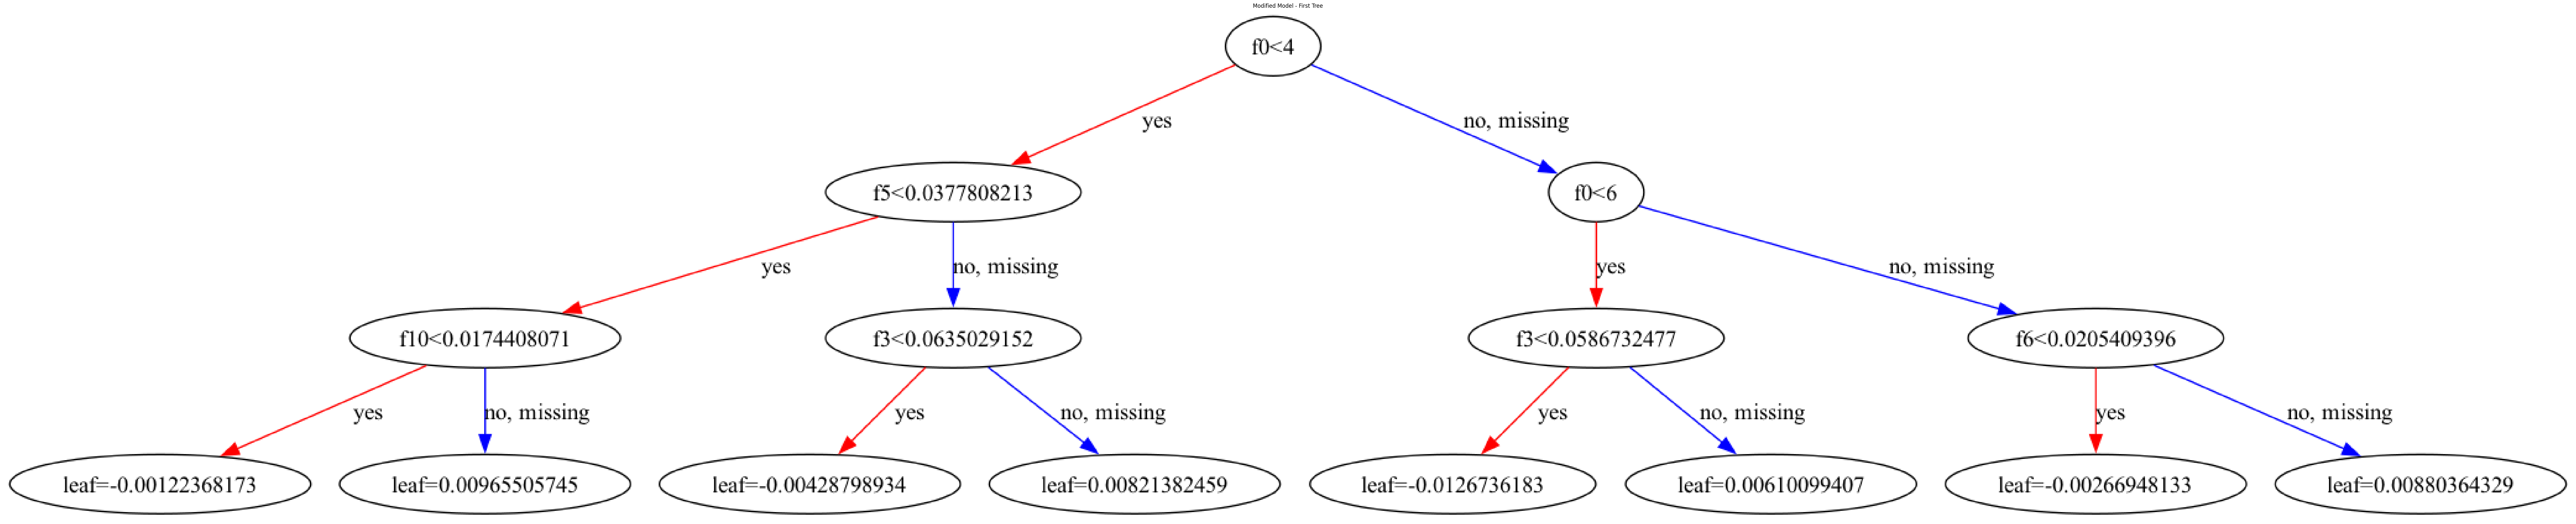

<Figure size 2000x1000 with 0 Axes>

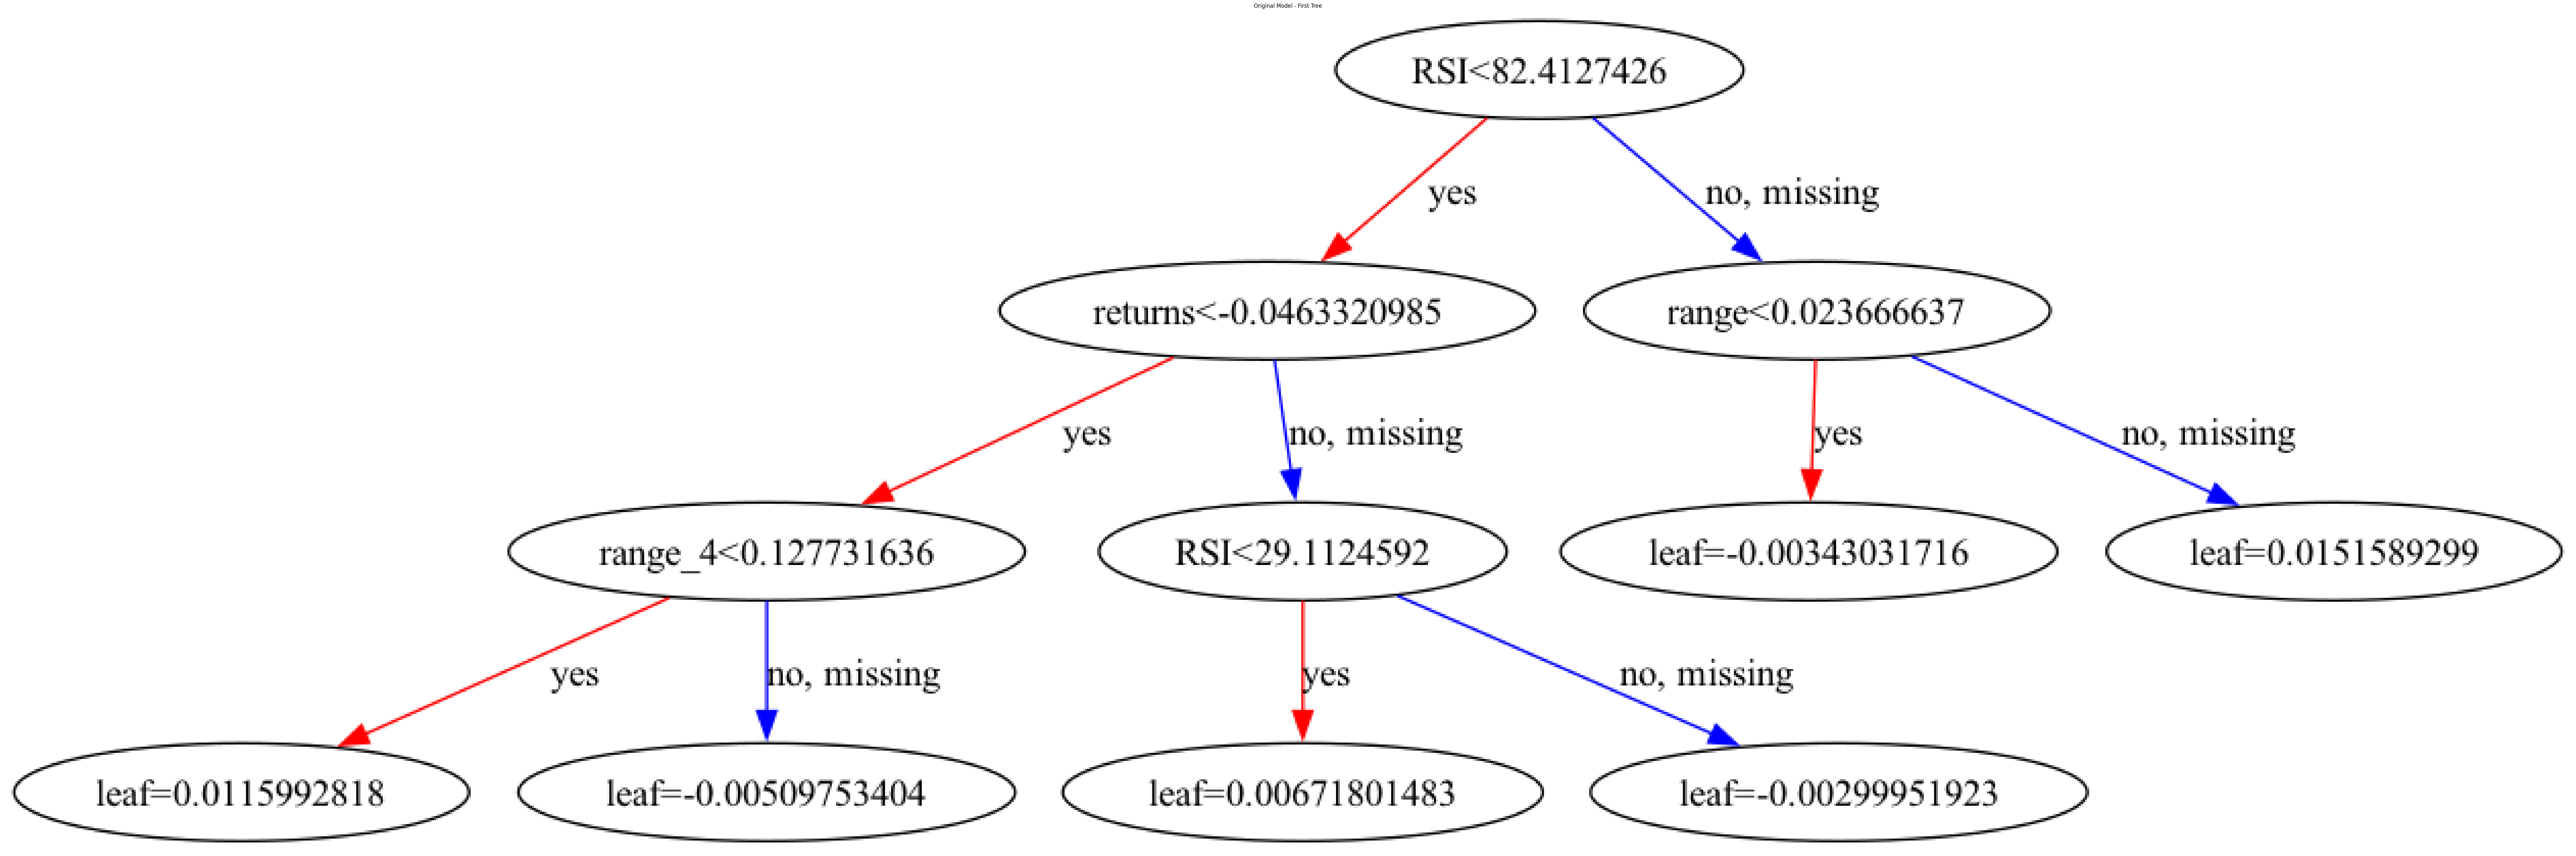

Modified Model - First Tree Info:
0:[f0<4] yes=1,no=2,missing=2
	1:[f5<0.0377808213] yes=3,no=4,missing=4
		3:[f10<0.0174408071] yes=7,no=8,missing=8
			7:leaf=-0.00122368173
			8:leaf=0.00965505745
		4:[f3<0.0635029152] yes=9,no=10,missing=10
			9:leaf=-0.00428798934
			10:leaf=0.00821382459
	2:[f0<6] yes=5,no=6,missing=6
		5:[f3<0.0586732477] yes=11,no=12,missing=12
			11:leaf=-0.0126736183
			12:leaf=0.00610099407
		6:[f6<0.0205409396] yes=13,no=14,missing=14
			13:leaf=-0.00266948133
			14:leaf=0.00880364329


Original Model - First Tree Info:
0:[RSI<82.4127426] yes=1,no=2,missing=2
	1:[returns<-0.0463320985] yes=3,no=4,missing=4
		3:[range_4<0.127731636] yes=7,no=8,missing=8
			7:leaf=0.0115992818
			8:leaf=-0.00509753404
		4:[RSI<29.1124592] yes=9,no=10,missing=10
			9:leaf=0.00671801483
			10:leaf=-0.00299951923
	2:[range<0.023666637] yes=5,no=6,missing=6
		5:leaf=-0.00343031716
		6:leaf=0.0151589299


Modified Model - Feature Importances:
DOW: 0.2066219300031662
volume: 0.08260

In [54]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
import xgboost as xgb

# Create a new instance of the classifier with the same parameters
classifier_mod = xgb.XGBClassifier(**classifier.get_params())

# Fit the new classifier on the modified data
classifier_mod.fit(X_test_mod, y_test)

# Now let's plot the first tree of the modified model
plt.figure(figsize=(20, 10))
plot_tree(classifier_mod, num_trees=0, feature_names=feature_columns)
plt.title("Modified Model - First Tree")
plt.tight_layout()
plt.show()

# Plot the original model's first tree for comparison
plt.figure(figsize=(20, 10))
plot_tree(classifier, num_trees=0, feature_names=feature_columns)
plt.title("Original Model - First Tree")
plt.tight_layout()
plt.show()

# Print out some information about the trees
print("Modified Model - First Tree Info:")
print(classifier_mod.get_booster().get_dump()[0])
print("\nOriginal Model - First Tree Info:")
print(classifier.get_booster().get_dump()[0])

# You can also compare feature importances
print("\nModified Model - Feature Importances:")
for feature, importance in zip(feature_columns, classifier_mod.feature_importances_):
    print(f"{feature}: {importance}")

print("\nOriginal Model - Feature Importances:")
for feature, importance in zip(feature_columns, classifier.feature_importances_):
    print(f"{feature}: {importance}")

In [59]:
import polars as pl
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import xgboost as xgb

def generate_rounded_report(y_true, y_pred):
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    df = pl.DataFrame({
        'class': ['0.0', '1.0', 'accuracy', 'macro avg', 'weighted avg'],
        'precision': [precision[0], precision[1], None, 
                      precision.mean(), (precision * support).sum() / support.sum()],
        'recall': [recall[0], recall[1], None, 
                   recall.mean(), (recall * support).sum() / support.sum()],
        'f1-score': [f1[0], f1[1], accuracy, 
                     f1.mean(), (f1 * support).sum() / support.sum()],
        'support': support.tolist() + [support.sum()] * 3
    })
    # Round numeric columns to 3 decimal places
    for col in ['precision', 'recall', 'f1-score']:
        df = df.with_columns(pl.col(col).round(3))
    return df

# Original model predictions
train_yhat_orig = classifier.predict(X_train)
test_yhat_orig = classifier.predict(X_test)

# Modified model predictions
classifier_mod = xgb.XGBClassifier(**classifier.get_params())
classifier_mod.fit(X_test_mod, y_test)
train_yhat_mod = classifier_mod.predict(X_train)
test_yhat_mod = classifier_mod.predict(X_test_mod)

# Generate reports for original model
print("Original Model:")
print("# Show summary report - Training")
train_report_orig = generate_rounded_report(y_train, train_yhat_orig)
print(train_report_orig)
print("\n# Show summary report - Test")
test_report_orig = generate_rounded_report(y_test, test_yhat_orig)
print(test_report_orig)

print("\nModified Model:")
print("# Show summary report - Training")
train_report_mod = generate_rounded_report(y_train, train_yhat_mod)
print(train_report_mod)
print("\n# Show summary report - Test")
test_report_mod = generate_rounded_report(y_test, test_yhat_mod)
print(test_report_mod)

Original Model:
# Show summary report - Training
shape: (5, 5)
┌──────────────┬───────────┬────────┬──────────┬─────────┐
│ class        ┆ precision ┆ recall ┆ f1-score ┆ support │
│ ---          ┆ ---       ┆ ---    ┆ ---      ┆ ---     │
│ str          ┆ f64       ┆ f64    ┆ f64      ┆ i64     │
╞══════════════╪═══════════╪════════╪══════════╪═════════╡
│ 0.0          ┆ 0.67      ┆ 0.986  ┆ 0.798    ┆ 1209    │
│ 1.0          ┆ 0.867     ┆ 0.159  ┆ 0.268    ┆ 699     │
│ accuracy     ┆ null      ┆ null   ┆ 0.683    ┆ 1908    │
│ macro avg    ┆ 0.768     ┆ 0.572  ┆ 0.533    ┆ 1908    │
│ weighted avg ┆ 0.742     ┆ 0.683  ┆ 0.604    ┆ 1908    │
└──────────────┴───────────┴────────┴──────────┴─────────┘

# Show summary report - Test
shape: (5, 5)
┌──────────────┬───────────┬────────┬──────────┬─────────┐
│ class        ┆ precision ┆ recall ┆ f1-score ┆ support │
│ ---          ┆ ---       ┆ ---    ┆ ---      ┆ ---     │
│ str          ┆ f64       ┆ f64    ┆ f64      ┆ i64     │
╞═══════

# Interpreting Results for BTC Trading Data and Improving Trading Strategy

## Target Variable Interpretation:
- **Class 1.0**: The next day's price range will be greater than the current day's average range.
- **Class 0.0**: The next day's price range will be less than or equal to the current day's average range.

## Updated Interpretation and Trading Strategy Improvements:

### Prediction Horizon:
- The model predicts increased volatility for the next day, not necessarily price direction.
- This is crucial for options trading, volatility-based strategies, and risk management.

### Original Model Performance:
- **High recall for Class 0.0**: Good at predicting when volatility will not increase.
- **Low recall but high precision for Class 1.0**: When it predicts increased volatility, it's often correct but misses many instances.

### Modified Model Performance:
- Slightly improved recall and precision for Class 1.0 in the test set.
- This suggests our feature modifications helped in identifying volatility increases.

## Improving Trading Strategy:

### 1. Volatility-based Trading:
- Use Class 1.0 predictions to enter positions that benefit from increased volatility (e.g., long straddles, strangles in options trading).
- The high precision for Class 1.0 suggests these trades could be profitable, albeit less frequent.

### 2. Risk Management:
- Use Class 0.0 predictions to identify periods of lower expected volatility.
- These periods might be suitable for strategies that perform better in stable markets (e.g., selling options, range-bound trading).

### 3. Position Sizing:
- Increase position sizes when the model predicts increased volatility (Class 1.0) due to the high precision.
- Use smaller positions or avoid trading when the model predicts normal/low volatility (Class 0.0).

### 4. Combining with Directional Predictions:
- Pair this volatility prediction with a separate directional prediction model.
- When both models align (e.g., high volatility prediction + strong directional signal), it could present high-conviction trade opportunities.

### 5. Timeframe Adjustment:
- Consider creating similar models for different timeframes (e.g., 2-day, weekly volatility predictions).
- This could help in planning longer-term option strategies or position trades.

### 6. Feature Engineering:
- The improvements in the modified model suggest that tweaking RSI, range, and returns helped predict volatility.
- Experiment with other volatility-related features (e.g., ATR, Bollinger Band Width, VIX for broader market volatility).

### 7. Asymmetric Payoff Strategies:
- Given the high precision but low recall for Class 1.0, focus on strategies with asymmetric payoffs for volatility increases.
- This could include long gamma strategies in options trading.

### 8. Sector and Market Regime Consideration:
- Bitcoin's volatility can be influenced by broader crypto market trends or specific events.
- Consider incorporating features that capture overall market sentiment or upcoming events that might impact volatility.

### 9. Continuous Model Updating:
- Regularly retrain the model to adapt to changing volatility regimes in the crypto market.
- Monitor the balance between Classes 0 and 1 over time to detect shifts in overall market volatility.

### 10. Complementary Indicators:
- Use traditional volatility indicators alongside the model predictions for confirmation.
- When both the model and traditional indicators suggest increased volatility, it could present stronger trading signals.

### 11. Volatility Mean Reversion:
- Be aware that periods of high volatility are often followed by lower volatility.
- Use the model's predictions in conjunction with this principle for mean reversion strategies.

## Conclusion:
By focusing on predicting next-day volatility rather than direct price movements, this model becomes a powerful tool for volatility-based trading strategies and risk management in the highly volatile Bitcoin market. The key is to leverage the model's strengths (high precision in predicting volatility spikes) while being aware of its limitations (lower recall for these events).


# Optimizing XGBoost Model Performance

## Feature Importance
- Use `plot_importance()` to visualize feature importance
- RSI appears to be the most important feature for predicting volatility

## Visualizing the Decision Tree
- Use `plot_tree()` to see the model's decision-making process
- Reveals which features and thresholds are used for predictions

## Hyperparameter Tuning
1. Adjust key hyperparameters:
   - `max_depth`: Controls tree complexity
   - `n_estimators`: Number of trees in the ensemble
   - `learning_rate`: Step size shrinkage to prevent overfitting

2. Experiment with different combinations:
   - Try `max_depth` of 2, 3, or 4
   - Increase `n_estimators` (e.g., from 80 to 120 or 150)
   - Keep `learning_rate` constant initially

3. Evaluate model performance after each change:
   - Check accuracy on training and test sets
   - Monitor standard deviation of predictions
   - Examine ROC curve and loss function

4. Find the balance:
   - Lower `max_depth` (e.g., 2) might give more stable results with lower standard deviation
   - Higher `n_estimators` can improve accuracy but watch for overfitting

## Advanced Techniques
- Consider incorporating Hidden Markov Model data
- Add probability projections to the dataframe
- Conduct backtesting with different probability thresholds
- Use Principal Component Analysis for feature engineering

## Final Steps
1. Choose a model configuration with:
   - Low standard deviation in predictions
   - Good precision (e.g., 60-65% range)
2. Fine-tune the decision threshold:
   - Analyze the ROC curve to determine optimal cutoff point
   - Adjust threshold (e.g., from 0.5 to 0.6) for more conservative predictions

Remember, while hyperparameter tuning is important, significant improvements often come from better data and feature engineering. Always balance model complexity with performance to avoid overfitting.